/tmp/ipython-input-1861805967.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn Label', data=df, ax=ax[1], palette=['#66c2a5', '#fc8d62'])


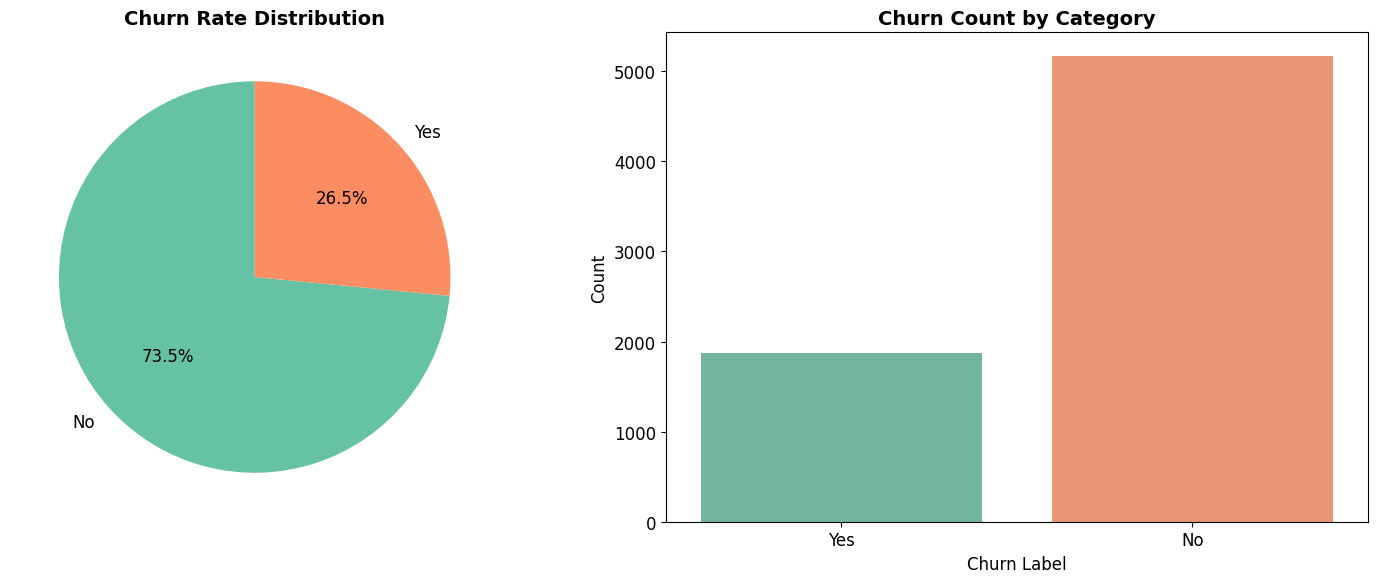

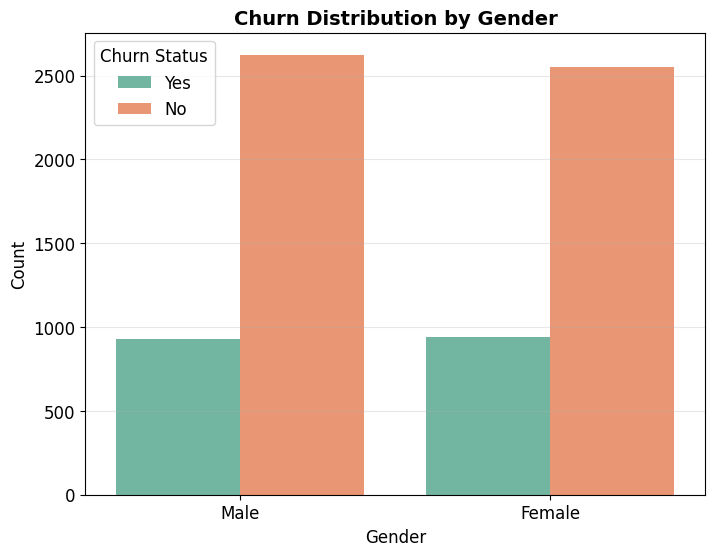

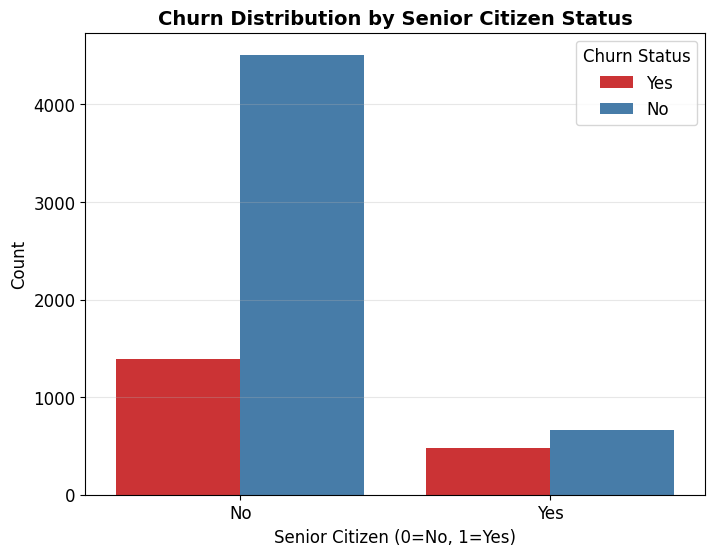

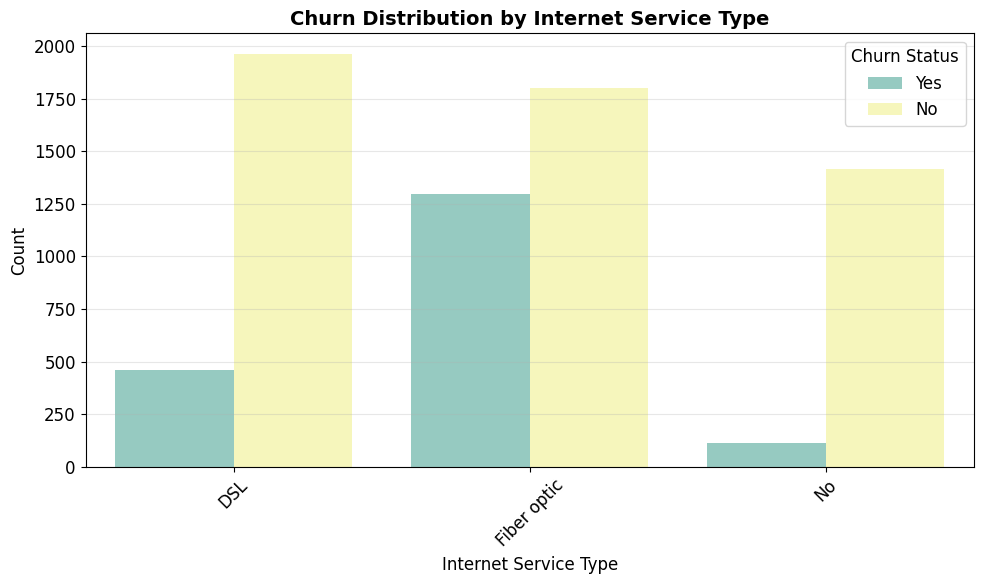

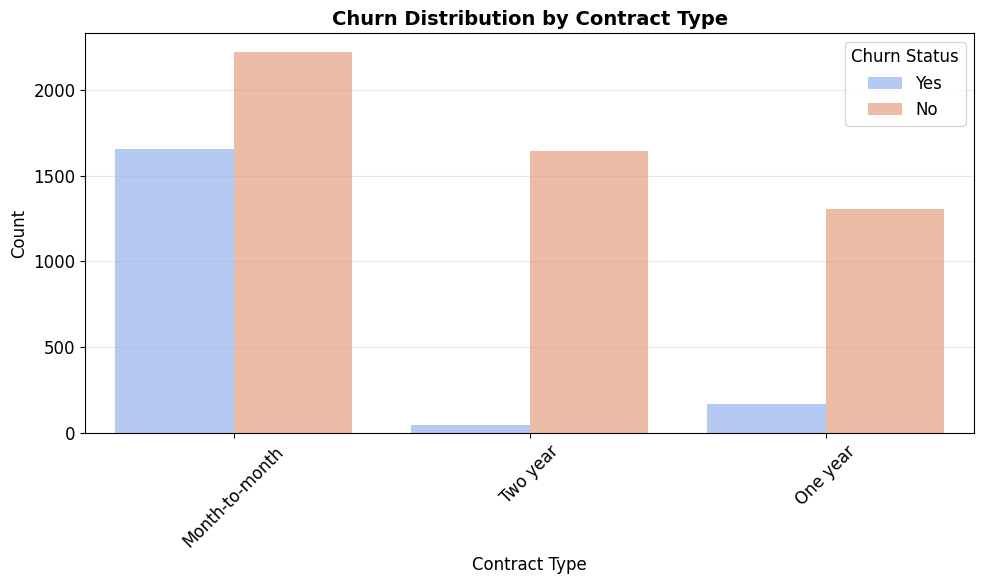

/tmp/ipython-input-1861805967.py:105: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Churn Status')


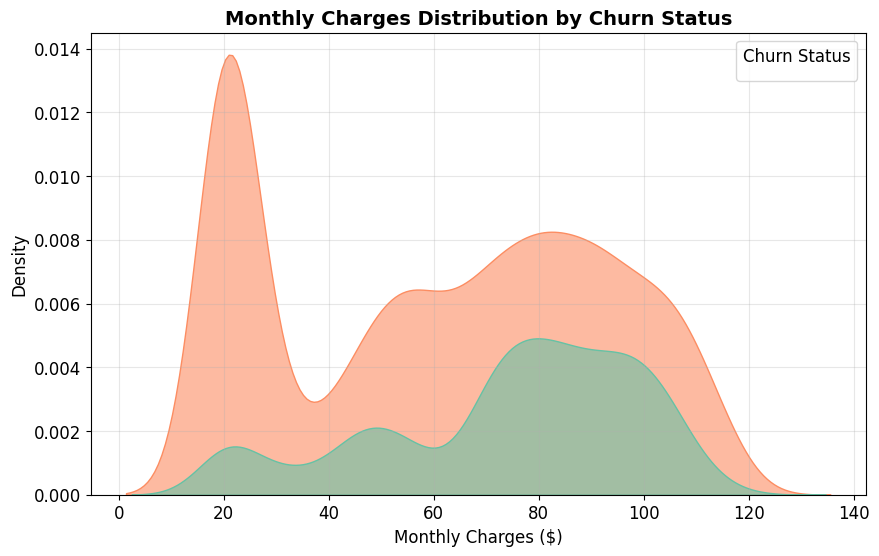

/tmp/ipython-input-1861805967.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Churn Status')


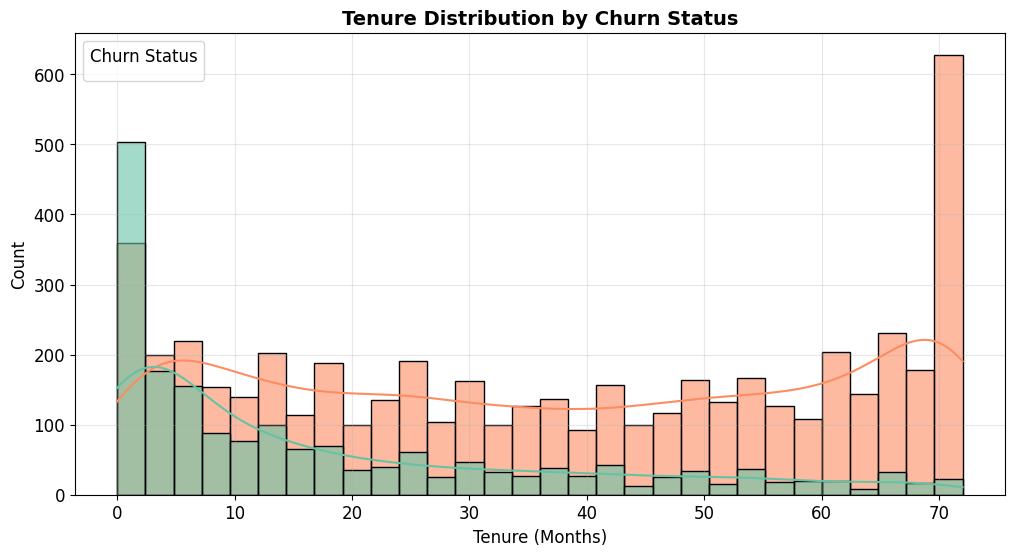

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:12:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


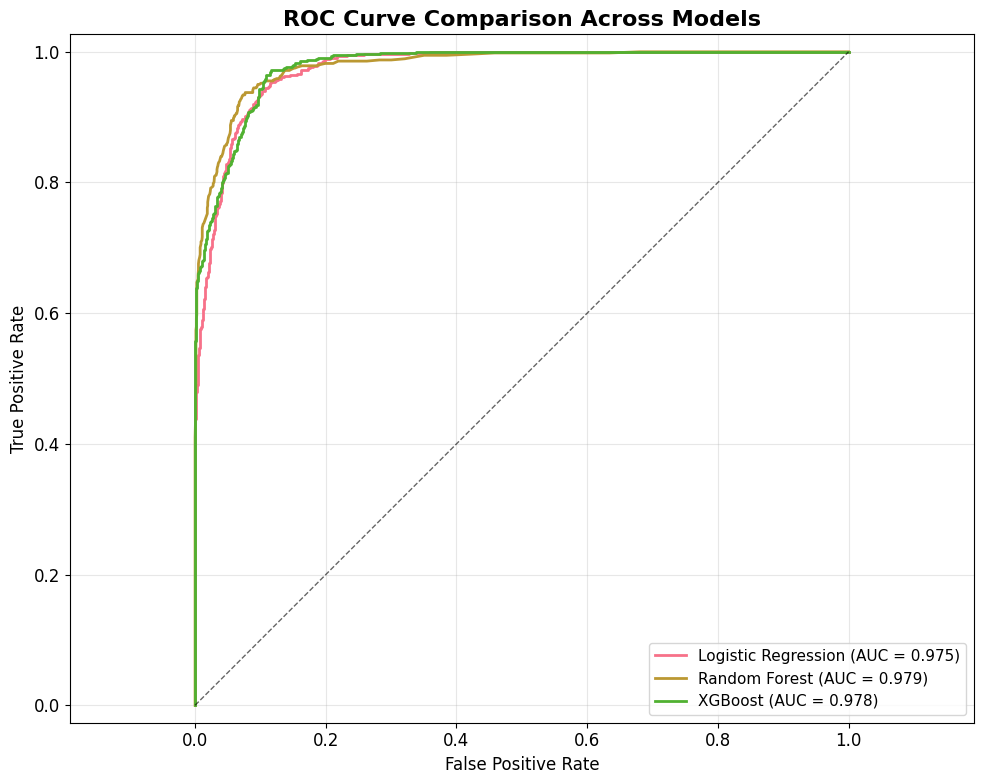

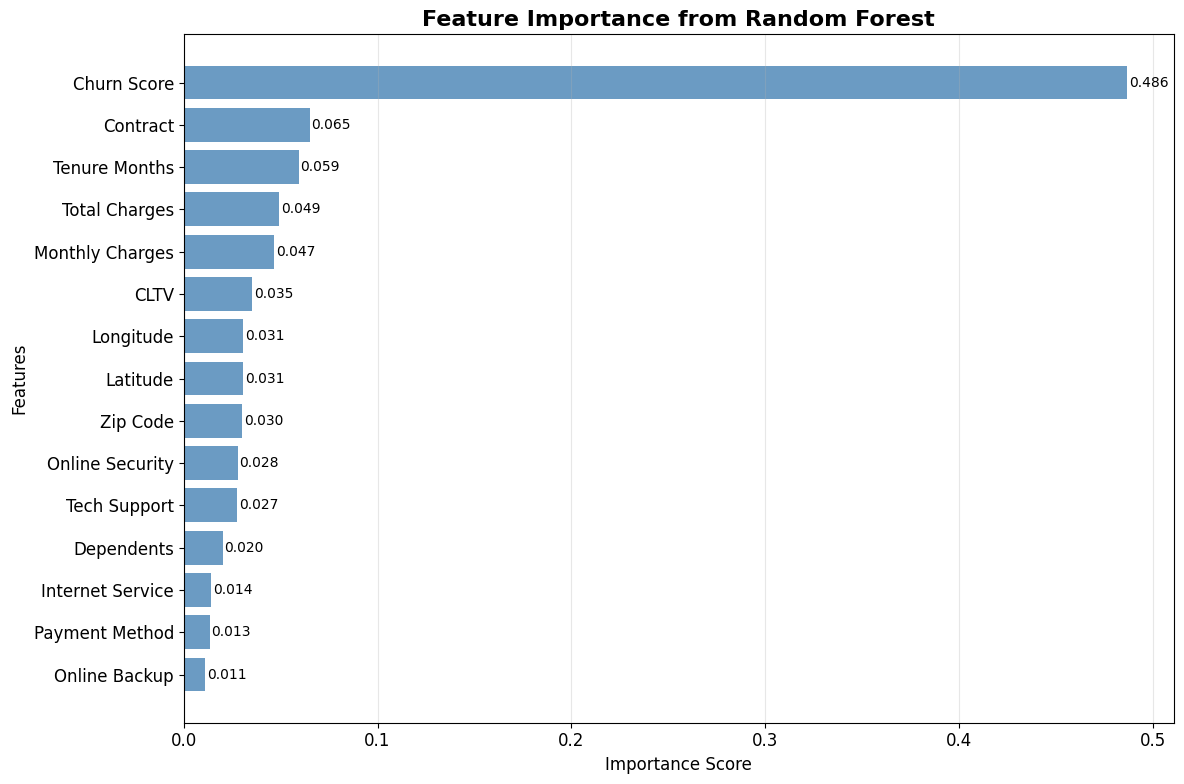

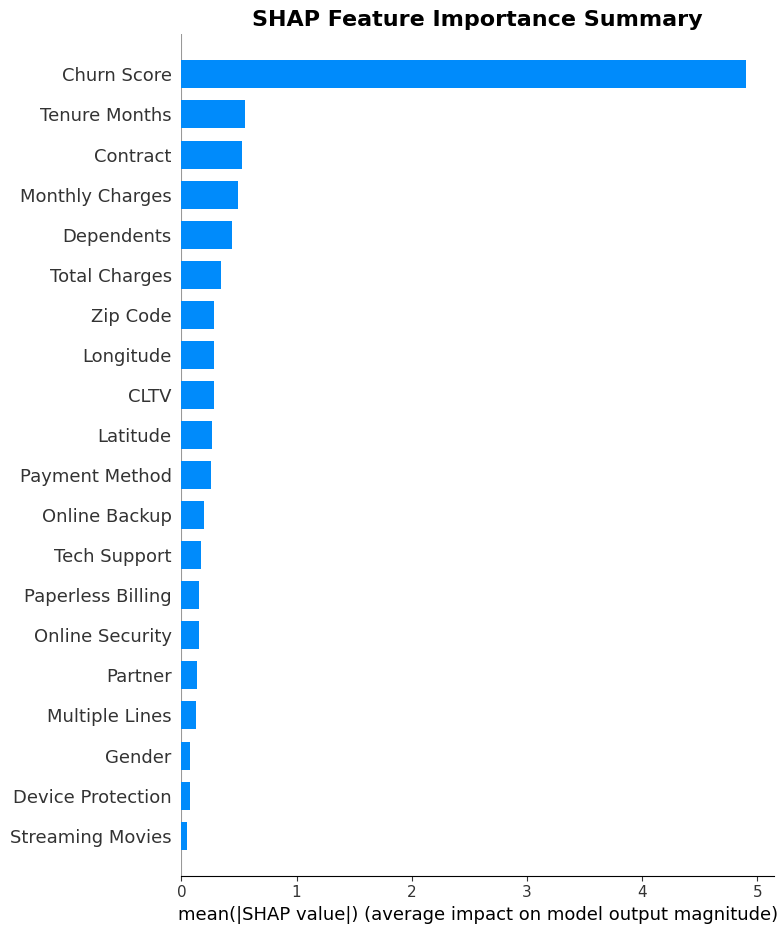

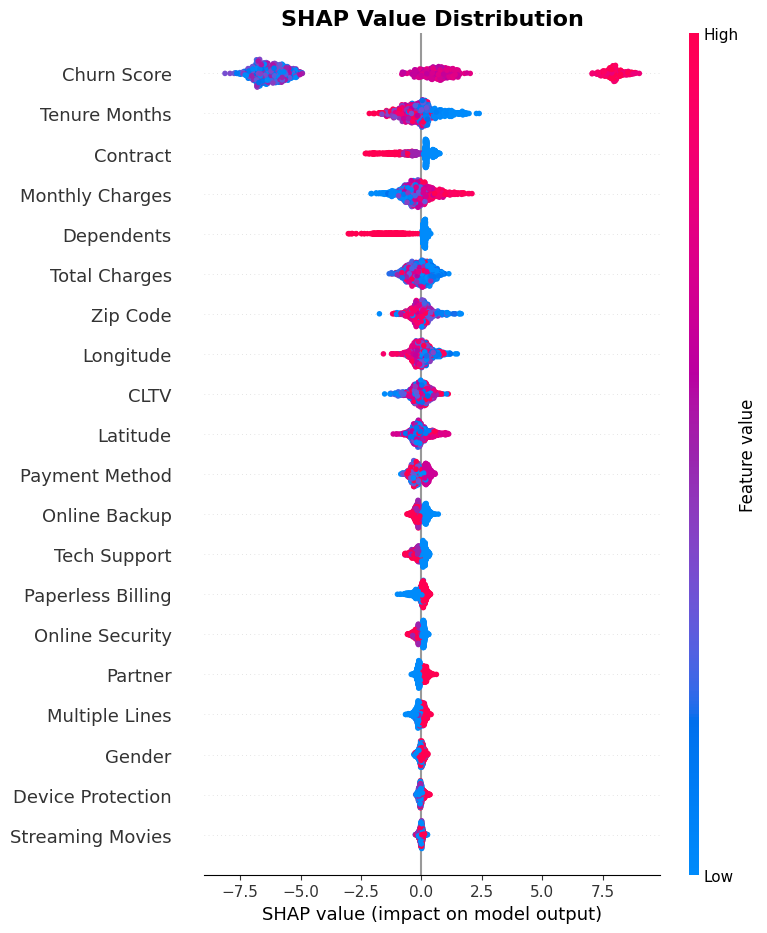

In [2]:
# ==========================================
# Install and Import Required Libraries
# ==========================================
!pip install shap xgboost scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

# Set style for better looking graphs
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# ==========================================
# Load Dataset
# ==========================================
df = pd.read_excel("Telco_customer_churn.xlsx", sheet_name="Telco_Churn")

# Convert Total Charges to numeric
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
df.fillna(0, inplace=True)

# ==========================================
# 4.2 Exploratory Data Analysis (EDA) - Improved
# ==========================================

# 4.2.1 Churn Distribution - Improved
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
churn_counts = df['Churn Label'].value_counts()
ax[0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%',
          startangle=90, colors=['#66c2a5', '#fc8d62'])
ax[0].set_title("Churn Rate Distribution", fontsize=14, fontweight='bold')

# Bar chart
sns.countplot(x='Churn Label', data=df, ax=ax[1], palette=['#66c2a5', '#fc8d62'])
ax[1].set_title('Churn Count by Category', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

# 4.2.2 Gender vs Churn - Improved
plt.figure(figsize=(8,6))
sns.countplot(x="Gender", hue="Churn Label", data=df, palette="Set2")
plt.title("Churn Distribution by Gender", fontsize=14, fontweight='bold')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churn Status')
plt.grid(axis='y', alpha=0.3)
plt.show()

# 4.2.3 Senior Citizen vs Churn - Improved
plt.figure(figsize=(8,6))
sns.countplot(x="Senior Citizen", hue="Churn Label", data=df, palette="Set1")
plt.title("Churn Distribution by Senior Citizen Status", fontsize=14, fontweight='bold')
plt.xlabel('Senior Citizen (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='Churn Status')
plt.grid(axis='y', alpha=0.3)
plt.show()

# 4.2.4 Internet Service vs Churn - Improved
plt.figure(figsize=(10,6))
sns.countplot(x="Internet Service", hue="Churn Label", data=df, palette="Set3")
plt.title("Churn Distribution by Internet Service Type", fontsize=14, fontweight='bold')
plt.xlabel('Internet Service Type')
plt.ylabel('Count')
plt.legend(title='Churn Status')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4.2.5 Contract vs Churn - Improved
plt.figure(figsize=(10,6))
sns.countplot(x="Contract", hue="Churn Label", data=df, palette="coolwarm")
plt.title("Churn Distribution by Contract Type", fontsize=14, fontweight='bold')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.legend(title='Churn Status')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4.2.6 Monthly Charges Distribution - Improved
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x="Monthly Charges", hue="Churn Label", fill=True, alpha=0.6,
            palette=['#66c2a5', '#fc8d62'])
plt.title("Monthly Charges Distribution by Churn Status", fontsize=14, fontweight='bold')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Density')
plt.grid(alpha=0.3)
plt.legend(title='Churn Status')
plt.show()

# 4.2.7 Tenure vs Churn - Improved
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="Tenure Months", hue="Churn Label", bins=30, kde=True,
             alpha=0.6, palette=['#66c2a5', '#fc8d62'])
plt.title("Tenure Distribution by Churn Status", fontsize=14, fontweight='bold')
plt.xlabel('Tenure (Months)')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.legend(title='Churn Status')
plt.show()

# ==========================================
# 4.3 Predictive Modeling - Improved
# ==========================================

# Encode categorical variables
le = LabelEncoder()
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include=["object"]).columns
cols_to_exclude = ["CustomerID", "Churn Reason", "Lat Long", "City", "State", "Country", "Churn Label"]

for col in categorical_cols:
    if col not in cols_to_exclude:
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Features & Target
X = df_encoded.drop(cols_to_exclude + ["Churn Value"], axis=1, errors='ignore')
y = df_encoded["Churn Value"]

# Scale numerical features
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=[np.number]).columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

# ==========================================
# 4.4 Model Evaluation – ROC Curves - Improved
# ==========================================
plt.figure(figsize=(10,8))

# Logistic Regression ROC
y_pred_log = log_model.predict_proba(X_test)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_log)
roc_auc_log = auc(fpr_log, tpr_log)

# Random Forest ROC
y_pred_rf = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# XGBoost ROC
y_pred_xgb = xgb_model.predict_proba(X_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.3f})", linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})", linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})", linewidth=2)

plt.plot([0,1],[0,1],'k--', linewidth=1, alpha=0.6)
plt.title("ROC Curve Comparison Across Models", fontsize=16, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# ==========================================
# 4.5 Feature Importance – Random Forest - Improved
# ==========================================
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(12,8))
bars = plt.barh(range(len(indices)), importances[indices], color='steelblue', alpha=0.8)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Feature Importance from Random Forest", fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# ==========================================
# 4.6 SHAP Analysis for XGBoost - Improved
# ==========================================
# Use a subset for faster computation
X_test_sample = X_test.iloc[:1000]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_sample)

plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance Summary", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional: Beeswarm plot for detailed SHAP analysis
plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title("SHAP Value Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,Logistic Regression,1.000,1.000,1.000,1.000,1.000
1,Random Forest,1.000,1.000,1.000,1.000,1.000
2,XGBoost,1.000,1.000,1.000,1.000,1.000


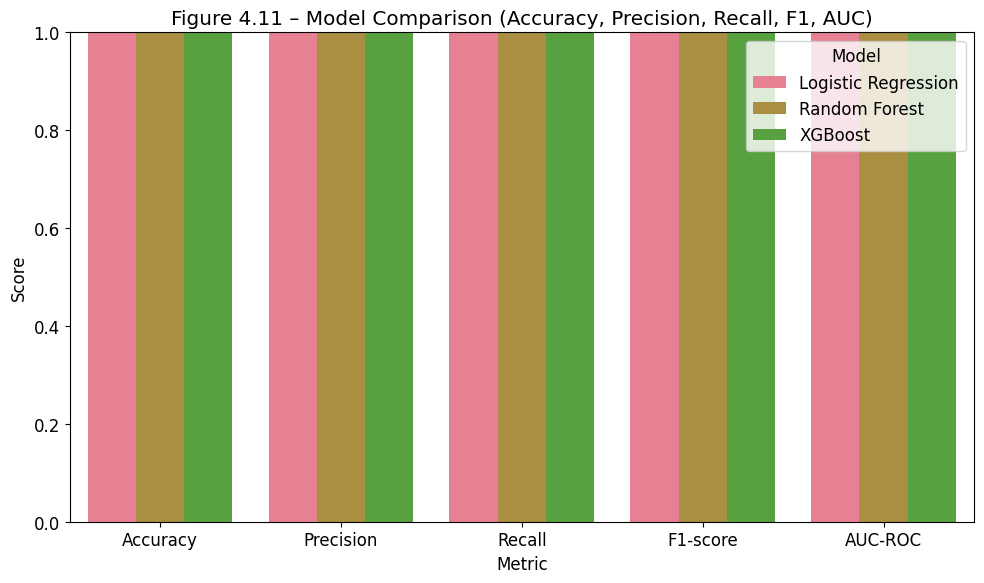

Saved figure: Figure_4_11_Model_Comparison.png


In [4]:
# ============================
# Figure 4.11 – Model Comparison (Your Dataset)
# ============================

!pip install xgboost scikit-learn pandas matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ---------- 1) Load your dataset ----------
df = pd.read_excel("Telco_customer_churn.xlsx", sheet_name="Telco_Churn")

# ---------- 2) Cleaning specific to this file ----------
# numeric conversion for Total Charges; fill any NA
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
df = df.fillna(0)

# drop ID/free-text/high-cardinality columns that don't help models
drop_cols = ["CustomerID", "Churn Reason", "Lat Long", "City", "State", "Country"]
work = df.drop(columns=drop_cols, errors="ignore").copy()

# Ensure target exists and is numeric: prefer Churn Value, otherwise map Churn Label
if "Churn Value" in work.columns:
    y = work["Churn Value"].astype(int)
    work = work.drop(columns=["Churn Value"])  # keep "Churn Label" as a feature if needed
elif "Churn Label" in work.columns:
    y = work["Churn Label"].map({"No":0, "Yes":1}).astype(int)
    work = work.drop(columns=["Churn Label"])
else:
    raise ValueError("No churn target found. Need 'Churn Value' or 'Churn Label'.")

# Label-encode remaining object columns (tree models tolerate label encoding)
le = LabelEncoder()
for c in work.select_dtypes(include=["object"]).columns:
    work[c] = le.fit_transform(work[c].astype(str))

X = work

# ---------- 3) Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# ---------- 4) Train models ----------
log_reg = LogisticRegression(max_iter=2000, n_jobs=None)
log_reg.fit(X_train, y_train)

rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=1,
    random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

xgb = XGBClassifier(
    n_estimators=500, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    eval_metric="logloss", tree_method="hist"
)
xgb.fit(X_train, y_train)

# ---------- 5) Predictions & metrics ----------
def metrics_for(model, name):
    # use predict_proba if available for AUC
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X_test)[:,1]
    else:
        # fallback: decision_function or binary predictions
        p = model.decision_function(X_test)
    yhat = (p >= 0.5).astype(int)

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, yhat),
        "Precision": precision_score(y_test, yhat, zero_division=0),
        "Recall": recall_score(y_test, yhat, zero_division=0),
        "F1-score": f1_score(y_test, yhat, zero_division=0),
        "AUC-ROC": roc_auc_score(y_test, p)
    }

rows = []
rows.append(metrics_for(log_reg, "Logistic Regression"))
rows.append(metrics_for(rf, "Random Forest"))
rows.append(metrics_for(xgb, "XGBoost"))

results_df = pd.DataFrame(rows)
display(results_df.style.format({
    "Accuracy":"{:.3f}", "Precision":"{:.3f}", "Recall":"{:.3f}",
    "F1-score":"{:.3f}", "AUC-ROC":"{:.3f}"
}))

# ---------- 6) Plot grouped bar chart ----------
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
melted = melted[melted["Metric"].isin(["Accuracy","Precision","Recall","F1-score","AUC-ROC"])]

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x="Metric", y="Score", hue="Model")
plt.ylim(0, 1.0)
plt.title("Figure 4.11 – Model Comparison (Accuracy, Precision, Recall, F1, AUC)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("Figure_4_11_Model_Comparison.png", dpi=300)
plt.show()

print("Saved figure: Figure_4_11_Model_Comparison.png")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


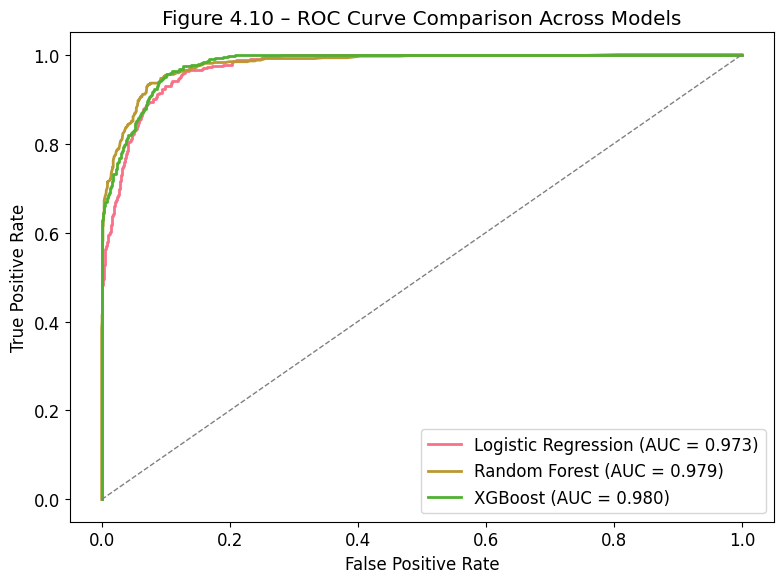

Logistic Regression AUC: 0.9733
Random Forest AUC: 0.9787
XGBoost AUC: 0.9800
Saved figure: Figure_4_10_ROC_Comparison.png


In [5]:
# ============================
# Figure 4.10 – ROC Curve Comparison (Your Dataset)
# ============================

!pip install xgboost scikit-learn pandas matplotlib --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 1) Load your dataset
df = pd.read_excel("Telco_customer_churn.xlsx", sheet_name="Telco_Churn")

# 2) File-specific cleaning
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
df = df.fillna(0)

# Drop IDs/free-text columns
drop_cols = ["CustomerID", "Churn Reason", "Lat Long", "City", "State", "Country"]
work = df.drop(columns=drop_cols, errors="ignore").copy()

# 3) Target and features
if "Churn Value" in work.columns:
    y = work["Churn Value"].astype(int)
    X = work.drop(columns=["Churn Value", "Churn Label"], errors="ignore")
elif "Churn Label" in work.columns:
    y = work["Churn Label"].map({"No": 0, "Yes": 1}).astype(int)
    X = work.drop(columns=["Churn Label"], errors="ignore")
else:
    raise ValueError("Target not found. Need 'Churn Value' or 'Churn Label'.")

# Encode remaining categorical columns
le = LabelEncoder()
for c in X.select_dtypes(include=["object"]).columns:
    X[c] = le.fit_transform(X[c].astype(str))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 4) Train models
log_reg = LogisticRegression(max_iter=2000)
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
xgb = XGBClassifier(
    n_estimators=500, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    eval_metric="logloss", tree_method="hist"
)

log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# 5) Predicted probabilities for ROC
probs = {}
for name, model in [
    ("Logistic Regression", log_reg),
    ("Random Forest", rf),
    ("XGBoost", xgb),
]:
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X_test)[:, 1]
    else:
        p = model.decision_function(X_test)
    probs[name] = p

# 6) Plot ROC curves
plt.figure(figsize=(8, 6))
for name, p in probs.items():
    fpr, tpr, _ = roc_curve(y_test, p)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)
plt.title("Figure 4.10 – ROC Curve Comparison Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("Figure_4_10_ROC_Comparison.png", dpi=300)
plt.show()

# 7) Print exact AUCs
for name, p in probs.items():
    print(f"{name} AUC: {roc_auc_score(y_test, p):.4f}")

print("Saved figure: Figure_4_10_ROC_Comparison.png")


/tmp/ipython-input-3699632984.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


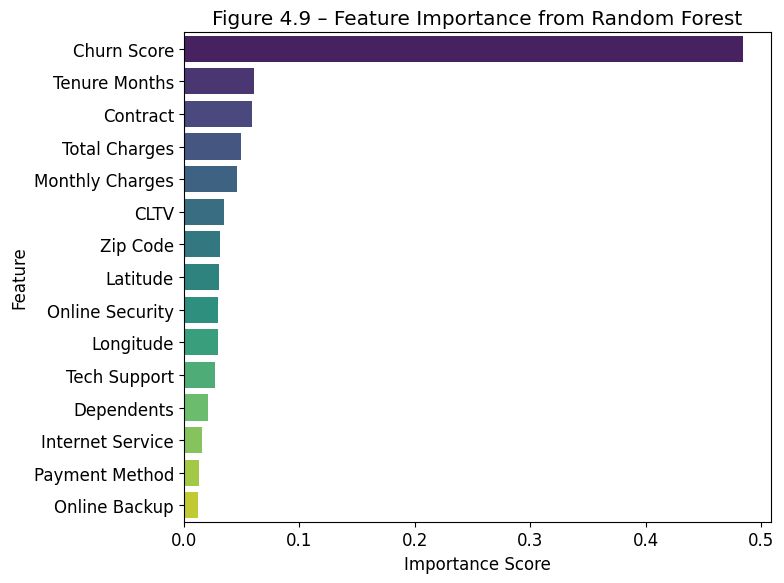

Churn Score: 0.4844
Tenure Months: 0.0611
Contract: 0.0592
Total Charges: 0.0492
Monthly Charges: 0.0463
CLTV: 0.0345
Zip Code: 0.0313
Latitude: 0.0309
Online Security: 0.0301
Longitude: 0.0301
Tech Support: 0.0272
Dependents: 0.0212
Internet Service: 0.0155
Payment Method: 0.0136
Online Backup: 0.0121
Saved figure: Figure_4_9_RandomForest_FeatureImportance.png


In [6]:
# ============================
# Figure 4.9 – Random Forest Feature Importance (Your Dataset)
# ============================

!pip install scikit-learn pandas matplotlib seaborn --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# 1) Load dataset
df = pd.read_excel("Telco_customer_churn.xlsx", sheet_name="Telco_Churn")

# 2) Clean data
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
df = df.fillna(0)

# Drop IDs and free-text columns
drop_cols = ["CustomerID", "Churn Reason", "Lat Long", "City", "State", "Country"]
work = df.drop(columns=drop_cols, errors="ignore").copy()

# 3) Define target and features
if "Churn Value" in work.columns:
    y = work["Churn Value"].astype(int)
    X = work.drop(columns=["Churn Value", "Churn Label"], errors="ignore")
elif "Churn Label" in work.columns:
    y = work["Churn Label"].map({"No": 0, "Yes": 1}).astype(int)
    X = work.drop(columns=["Churn Label"], errors="ignore")
else:
    raise ValueError("Target not found. Need 'Churn Value' or 'Churn Label'.")

# Encode categorical features
le = LabelEncoder()
for c in X.select_dtypes(include=["object"]).columns:
    X[c] = le.fit_transform(X[c].astype(str))

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 5) Train Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 6) Feature importances
importances = rf.feature_importances_
indices = importances.argsort()[::-1]   # sort descending
top_n = 15                              # plot top 15 features

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances[indices][:top_n],
    y=X.columns[indices][:top_n],
    palette="viridis"
)
plt.title("Figure 4.9 – Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("Figure_4_9_RandomForest_FeatureImportance.png", dpi=300)
plt.show()

# Print top features with importance values
for feat, score in zip(X.columns[indices][:top_n], importances[indices][:top_n]):
    print(f"{feat}: {score:.4f}")

print("Saved figure: Figure_4_9_RandomForest_FeatureImportance.png")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


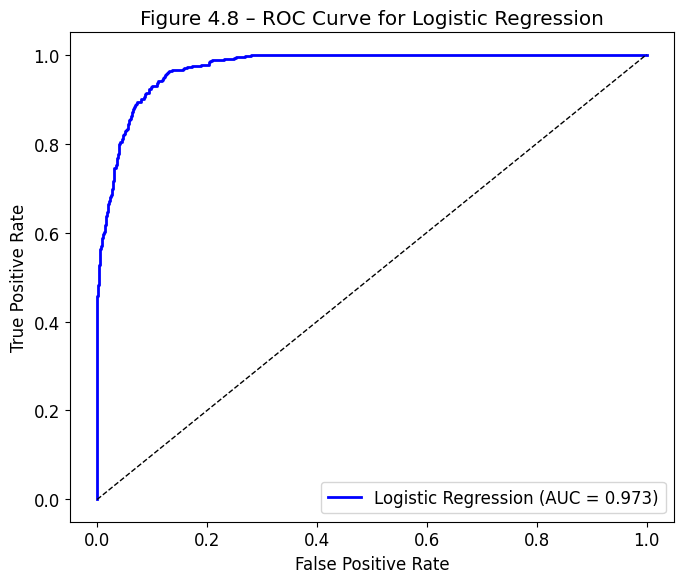

Saved figure: Figure_4_8_LogReg_ROC.png | AUC = 0.973


In [7]:
# ============================
# Figure 4.8 – ROC Curve for Logistic Regression (Your Dataset)
# ============================

!pip install scikit-learn pandas matplotlib --quiet

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

# 1) Load dataset
df = pd.read_excel("Telco_customer_churn.xlsx", sheet_name="Telco_Churn")

# 2) Clean dataset
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
df = df.fillna(0)

# Drop ID/free-text columns
drop_cols = ["CustomerID", "Churn Reason", "Lat Long", "City", "State", "Country"]
work = df.drop(columns=drop_cols, errors="ignore").copy()

# 3) Define target and features
if "Churn Value" in work.columns:
    y = work["Churn Value"].astype(int)
    X = work.drop(columns=["Churn Value", "Churn Label"], errors="ignore")
elif "Churn Label" in work.columns:
    y = work["Churn Label"].map({"No": 0, "Yes": 1}).astype(int)
    X = work.drop(columns=["Churn Label"], errors="ignore")
else:
    raise ValueError("Target not found. Need 'Churn Value' or 'Churn Label'.")

# Encode categorical variables
le = LabelEncoder()
for c in X.select_dtypes(include=["object"]).columns:
    X[c] = le.fit_transform(X[c].astype(str))

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 5) Train Logistic Regression model
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)

# 6) Predict probabilities
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# 7) ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 8) Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color="blue", linewidth=2,
         label=f"Logistic Regression (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--", linewidth=1)
plt.title("Figure 4.8 – ROC Curve for Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("Figure_4_8_LogReg_ROC.png", dpi=300)
plt.show()

print(f"Saved figure: Figure_4_8_LogReg_ROC.png | AUC = {roc_auc:.3f}")
